In [2]:
%pylab inline

import os
import numpy as np
import astropy.table as astTable
import matplotlib.pyplot as plt
import fitsio

from matplotlib.path import Path
import matplotlib.patches as patches

import lsst.geom as afw_geom
import lsst.afw.cameraGeom as cameraGeom
import lsst.daf.butler as db

import smatch

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
repo = "/work/xiangchong.li/work/hsc_s23b_sim/sim_cosmos/dc2"
butler = db.Butler(repo)
registry = butler.registry
skymap = butler.get("skyMap", collections="sim",  dataId={"skymap": "hsc"})

In [314]:
version = 1
catalog_file_name = f"/work/xiangchong.li/work/hsc_s23b_sim/catalogs/tracts_fdfc_v{version}_trim2.fits"
data = astTable.Table.read(catalog_file_name)

In [169]:
field = []
for ss in data:
    tract = ss["tract"]
    patch = ss["patch"]
    tractInfo = skymap[tract]
    wcs = tractInfo.getWcs()
    patchInfo = tractInfo.getPatchInfo([int(patch//100), int(patch%100)])
    patchBox = afw_geom.Box2D(patchInfo.getInnerBBox())

    tract_center = wcs.pixelToSky(patchBox.getCenter()).getPosition(afw_geom.degrees)
    ra = tract_center[0]
    dec = tract_center[1]
    if dec > 10.0:
        field.append("hectomap")
    else:
        if 125.0 < ra < 235.0:
            field.append("spring")
        else:
            field.append("autumn")
data["field"] = field
data.write(catalog_file_name, overwrite=True)

In [170]:
ra = []
dec = []
tract_list = data["tract"]
patch_list = data["patch"]

for tract, patch in zip(tract_list, patch_list):
    tractInfo = skymap[tract]
    wcs = tractInfo.getWcs()
    patchInfo = tractInfo.getPatchInfo([int(patch//100), int(patch%100)])
    patchBox = afw_geom.Box2D(patchInfo.getOuterBBox())
    patch_center = wcs.pixelToSky(patchBox.getCenter()).getPosition(afw_geom.degrees)
    ra.append(patch_center[0])
    dec.append(patch_center[1])
data["ra"] = np.array(ra)
data["dec"] = np.array(dec)
data.write(catalog_file_name, overwrite=True)

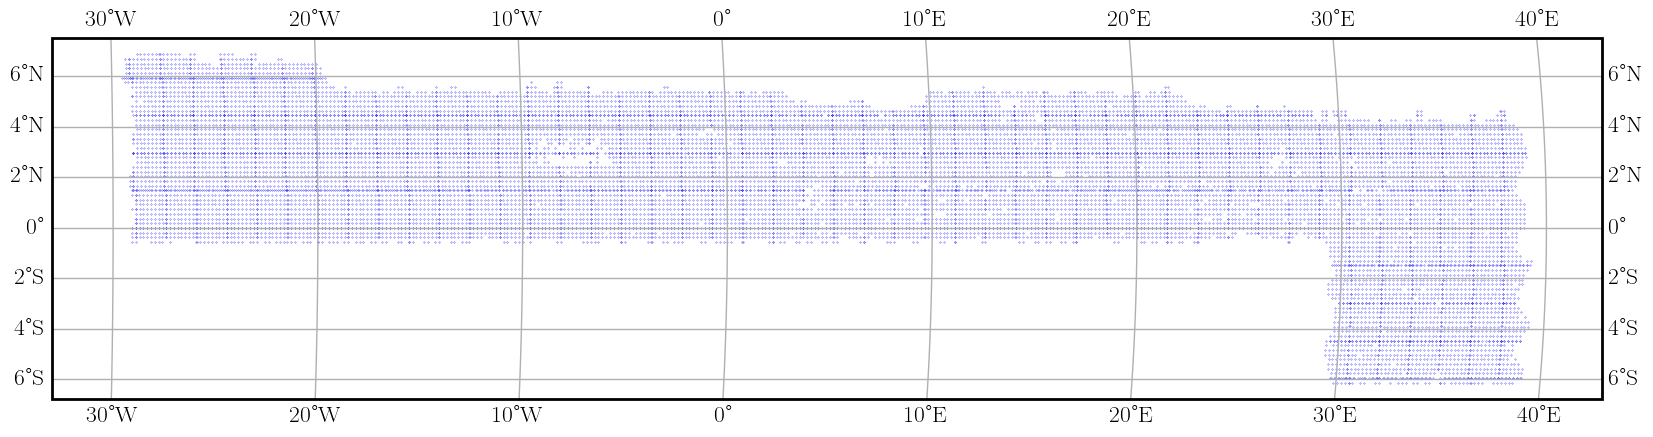

In [315]:
import cartopy.crs as ccrs
mask = data["field"] == "autumn"
ra = data[mask]["ra"]
dec = data[mask]["dec"]

# Convert RA/Dec to Cartesian coordinates for projection
projection = ccrs.Mollweide(central_longitude=310)  # Using Mollweide projection
fig, ax = plt.subplots(
    subplot_kw={"projection": projection}, 
    figsize=(20,6),
)

# Plot data points
ax.scatter(ra, dec, marker="o", color="blue", s=0.05, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()

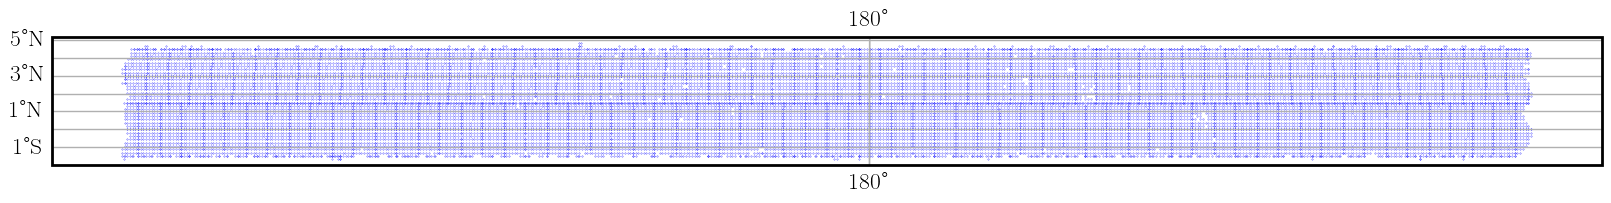

In [316]:
mask = data["field"] == "spring"
ra = data[mask]["ra"]
dec = data[mask]["dec"]

# Convert RA/Dec to Cartesian coordinates for projection
projection = ccrs.Mollweide(central_longitude=185)  # Using Mollweide projection
fig, ax = plt.subplots(
    subplot_kw={"projection": projection}, 
    figsize=(20,6),
)

# Plot data points
ax.scatter(ra, dec, marker="o", color="blue", s=0.05, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()

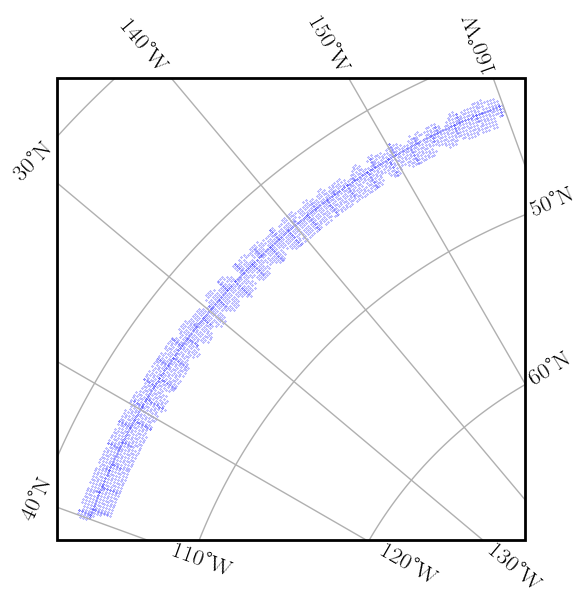

In [317]:
mask = data["field"] == "hectomap"
ra = data[mask]["ra"]
dec = data[mask]["dec"]

# Convert RA/Dec to Cartesian coordinates for projection
projection = ccrs.NorthPolarStereo()
fig, ax = plt.subplots(
    subplot_kw={"projection": projection}, 
    figsize=(10,6),
)

# Plot data points
ax.scatter(ra, dec, marker="o", color="blue", s=0.05, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()

In [182]:
# Maximum angular separation (in degrees)
max_distance = 0.168 * 4100 / 3600.0 * 1.5

ra = data["ra"]
dec = data["dec"]
# Perform the matching
res = smatch.match(
    ra1=ra, dec1=dec, radius1=max_distance, ra2=ra, dec2=dec, maxmatch=5
)
_, indices, counts = np.unique(res["i1"], return_counts=True, return_index=True)
ind = res["i1"][indices[counts > 4]]
catalog_file_name2 = f"/work/xiangchong.li/work/hsc_s23b_sim/catalogs/tracts_fdfc_v{version}_trim2.fits"
data2 = data[ind]
data2.write(catalog_file_name2, overwrite=True)

In [222]:
input_list = "("
tracts = list(np.unique(data2["tract"]))
t0 = 0
tracts_u = tracts + [0]
for i, tt in enumerate(tracts):
    if tt == t0 + 1:
        if tracts_u[i+1] != tt + 1:
            input_list += (str(tt) + ", ")
    else:
        if tracts_u[i+1] != tt + 1:
            input_list += (str(tt) + ", ")
        else:
            input_list += (str(tt) + "..")
    t0 = tt
input_list = input_list[:-2] + ")"

In [306]:
import healpy as hp
version = 1
catalog_file_name = f"/work/xiangchong.li/work/hsc_s23b_sim/catalogs/tracts_fdfc_v{version}_trim2.fits"
data = astTable.Table.read(catalog_file_name)
data2 = data[np.random.permutation(len(data))]

# Convert RA/Dec to radians
ra_rad = np.radians(data2["ra"])
dec_rad = np.radians(data2["dec"])

# Convert to HEALPix theta (colatitude) and phi (longitude)
theta = np.pi / 2 - dec_rad  # Colatitude
phi = ra_rad  # Longitude

# HEALPix resolution parameter (Nside)
nside = 128  # Must be a power of 2

# Compute HEALPix pixel numbers in the NESTED scheme
pixels = hp.ang2pix(nside, theta, phi, nest=True)

In [307]:
data2 = data2[np.unique(pixels, return_index=True)[1]]
data2.write(f"/work/xiangchong.li/work/hsc_s23b_sim/catalogs/tracts_fdfc_v{version}_trim2_sim.fits", overwrite=True)

In [325]:
catalog_file_name = f"/work/xiangchong.li/work/hsc_s23b_sim/catalogs/tracts_fdfc_v{version}_trim2.fits"
data = astTable.Table.read(catalog_file_name)
data2 = data[np.random.permutation(len(data))]

# Convert RA/Dec to radians
ra_rad = np.radians(data2["ra"])
dec_rad = np.radians(data2["dec"])

# Convert to HEALPix theta (colatitude) and phi (longitude)
theta = np.pi / 2 - dec_rad  # Colatitude
phi = ra_rad  # Longitude

# HEALPix resolution parameter (Nside)
nside = 256  # Must be a power of 2

# Compute HEALPix pixel numbers in the NESTED scheme
pixels = hp.ang2pix(nside, theta, phi, nest=True)
hp.nside2pixarea(nside) * (180 / np.pi) ** 2.0 * len(np.unique(pixels))

1081.5347735602397

In [324]:
hp.nside2pixarea(nside) * (180 / np.pi) ** 2.0

0.013113963206424481

In [ ]:
import fitsio
full = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")
id_list = []
for i, entry in enumerate(full):
    tract_id = entry["tract"]
    patch_db = entry["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_y + patch_x * 9
    image_dir = (
        "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_calexp"
    )
    files = glob.glob(os.path.join(image_dir, f"{tract_id}/{patch_id}/*/*"))
    if len(files) > 4:
        id_list.append(i)
fitsio.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim3.fits", full[id_list])

In [3]:
import glob

In [5]:
if False:
    fnames = glob.glob("/work/xiangchong.li/work/hsc_s23b_sim/version1/anacal_catalog/20250622T182000Z/sim_0_rot0_Coadd_anacal_joint/*/*/*.parq")
    tracts = np.array([int(fn.split("/")[-3]) for fn in fnames])
    patches = np.array([int(fn.split("/")[-2]) for fn in fnames])
    tps = tracts * 1000 + patches
    tp_list =fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits")
    patch_db = tp_list["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_ids = patch_x + patch_y * 9
    sims = tp_list[np.in1d(tp_list["tract"] * 1000 + patch_ids, tps)]
    fitsio.write("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final_sims.fits", sims)
else:
    sims = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final_sims.fits")

In [23]:
root_dir = "/work/xiangchong.li/work/hsc_s23b_sim2/systematics/20250301T190954Z/deepCoadd_systematics_psfcentered/"
out_root = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_psf_sim/"
for ss in sims:
    tract_id = ss["tract"]
    patch_db = ss["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_x + patch_y * 9
    for band in "grizy":
        fname = glob.glob(
            os.path.join(
                root_dir, 
                f"{tract_id}/{patch_id}/{band}/*.fits"
            )
        )[0]
        out_dir = os.path.join(out_root, f"{tract_id}/{patch_id}/{band}")
        os.makedirs(out_dir, exist_ok=True)
        os.popen(f"cp {fname} {out_dir}")

In [ ]:
if False:
    tplist = astTable.Table.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits")
    offsets = astTable.Table.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/color_offset.fits")
    _, id1, id2 = np.intersect1d(offsets["skymap_id"], tplist["tract"]*10000 + tplist["patch"], return_indices=True)
    tplist["g_mag_offset"] = 0.0
    tplist["r_mag_offset"] = 0.0
    tplist["i_mag_offset"] = 0.0
    tplist["z_mag_offset"] = 0.0
    tplist["y_mag_offset"] = 0.0
    tplist["g_mag_offset"][id2] = offsets["g_mag_offset"][id1]
    tplist["r_mag_offset"][id2] = offsets["r_mag_offset"][id1]
    tplist["i_mag_offset"][id2] = offsets["i_mag_offset"][id1]
    tplist["z_mag_offset"][id2] = offsets["z_mag_offset"][id1]
    tplist["y_mag_offset"][id2] = offsets["y_mag_offset"][id1]
    
    tplist["g_mag_offset"][tplist["g_mag_offset"] < -50] = 0.0
    tplist["i_mag_offset"][tplist["i_mag_offset"] > 50] = 0.0
    tplist.write("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits", overwrite=True)